<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/Data%20/Snow/2023_3_14_SWE_analysis_data_from_NOAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# GET DATA

import os
import urllib
import functools

import numpy as np
import pandas as pd

# if we don't have the stations file locally, download it
  if not os.path.isfile('stations.txt'):
      urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt',
                                'stations.txt')
      
    
  # FORMAT OF "ghcnd-stations.txt"
  # ------------------------------
  # Variable   Columns   Type
  # ------------------------------
  # ID            1-11   Character
  # LATITUDE     13-20   Real
  # LONGITUDE    22-30   Real
  # ELEVATION    32-37   Real
  # STATE        39-40   Character
  # NAME         42-71   Character
  # GSN FLAG     73-75   Character
  # HCN/CRN FLAG 77-79   Character
  # WMO ID       81-85   Character
  # ------------------------------


  # parse the stations.txt file as described in video 05_02
  allstations = np.genfromtxt('stations.txt', delimiter=[11,9,10,7,3,31,4,4,6],
                                              usecols=[0,1,2,3,4,5,6,7,8],
                                              names=['id','latitude','longitude','elevation','state','name','gsn','hcn','wmo'],
                                              dtype=['U11','d','d','d','U3','U31','U4','U4','U6'],
                                              autostrip=True)

  def getfile(station_name):  
      """Download the dly file for station_name, and return the local filename.
      
      If station_name is not in the list, find a station that _begins_
      with station_name, but give precedence to HCN and GSN stations."""
      
      # name of the local file
      station_file = f'{station_name}.dly'
      
      # if we don't have the file locally...
      if not os.path.isfile(station_file):
          # figure out the station id from the stations.txt file
          
          # start with all the station with names that begin as requested
          stations = allstations[np.char.find(allstations['name'], station_name) == 0]

          if len(stations) == 0:
              raise IOError("Station not available.")
          
          # we prefer GSN stations if available, then HCN, then we default to the first match
          if np.any(stations['gsn'] != ''):
              station = stations[stations['gsn'] != ''][0]
          elif np.any(stations['hcn'] != ''):
              station = stations[stations['hcn'] != ''][0]
          else:
              station = stations[0]
          
          print(f"Using {station}.")
          
          # compose the URL at which we expect to find the data
          url = f'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{station["id"]}.dly'
          
          print(f'Downloading {url}...')
          
          # download it to the local file
          urllib.request.urlretrieve(url, station_file)
          
      return station_file
      

  # FORMAT OF "*.dly" files
  # ------------------------------
  # Variable   Columns   Type
  # ------------------------------
  # ID            1-11   Character
  # YEAR         12-15   Integer
  # MONTH        16-17   Integer
  # ELEMENT      18-21   Character
  # VALUE1       22-26   Integer
  # MFLAG1       27-27   Character
  # QFLAG1       28-28   Character
  # SFLAG1       29-29   Character
  # VALUE2       30-34   Integer
  # MFLAG2       35-35   Character
  # QFLAG2       36-36   Character
  # SFLAG2       37-37   Character
  #   .           .          .
  #   .           .          .
  #   .           .          .
  # VALUE31    262-266   Integer
  # MFLAG31    267-267   Character
  # QFLAG31    268-268   Character
  # SFLAG31    269-269   Character
  # ------------------------------
      

  # cache the results of this call so we do the work only once
  @functools.lru_cache()
  def getdata(station_name):
      """Make a pandas DataFrame with clean weather data for station_name.
      
      If station_name cannot be found, find a station that _begins_
      with station_name, but give precedence to HCN and GSN stations."""
      
      station_file = getfile(station_name)
      
      # load the fixed-width file following its definition in readme.txt
      # note that there are 31 sequences of values + flags, one of each day of the month
      # (some will be undefined for some months)
      w = np.genfromtxt(station_file,
                        delimiter=[11,4,2,4] + [5,1,1,1]*31,
                        # we will not use the daily flags, so this list becomes
                        # 0, 1, 2, 3, 4, 8, 12, 16, 20, 24...
                        usecols=[0,1,2,3] + list(range(4,4*32,4)),
                        # the names of the daily observations will be day1, day2, day3, ...
                        names=['id','year','month','element'] + [f'day{i}' for i in range(1,32)],
                        dtype=['U11','i','i','U4'] + ['d']*31,
                        autostrip=True)

      # convert the numpy record array to a pandas DataFrame, a more powerful object
      # for cleaning and restructuring data
      pw = pd.DataFrame(w)

      # "melt" the daily observations into one record per daily observation,
      # storing the column name in 'day'
      pw = pd.melt(pw, id_vars=['id','year','month','element'], var_name='day', value_name='value')
      
      # throw away null observations
      pw = pw[pw.value != -9999]

      # keep only min/max temperatures, precipitation, and snow
      pw = pw[pw.element.isin(['TMAX','TMIN','PRCP','SNOW'])]

      # convert 'day1', 'day2', etc. to the number of the day 
      pw['day'] = pw.day.apply(lambda x: int(x[3:]))
      
      # make a date out of year, month, day
      pw['date'] = pd.to_datetime(pw[['year','month','day']])

      # keep only data, element, and value
      pw = pw[['date','element','value']]

      # restructure the DataFrame so that different elements for the same day appear in the same row
      # (basically the opposite of melt)
      pw = pw.pivot(index='date', columns='element')['value']
      pw.columns.name = None    
      pw = pw[['TMIN','TMAX','PRCP','SNOW']]
      
      # last, convert temperatures to degrees
      pw['TMIN'] /= 10.0
      pw['TMAX'] /= 10.0
      
      # wow, all done
      return pw


  def getyear(station_name, elements, year):
      """Make a NumPy record array of length 365, containing weather data
      at station_name for the list of requested elements (TMIN/TMAX/PRCP/SNOW),
      restricted to year.
      
      If station_name is not in the list, find a station that _begins_
      with station_name, but give precedence to HCN and GSN stations.
      """
          
      alldata = getdata(station_name)
      
      # select data by year, and get rid of the extra day in leap years
      # then pick out the "element" column
      yeardata = alldata[(alldata.index.year == year) & (alldata.index.dayofyear < 366)]
      
      # make an empty record array full of nans
      empty = np.full(365, np.nan, dtype=[(element, np.float64) for element in elements])
      
      for element in elements:    
          # fill it with values, using day of the year (1 to 365) as index
          empty[element][yeardata.index.dayofyear - 1] = yeardata[element].values
      
      return empty

In [ ]:
#Thanks https://github.com/Gare-Uti/Gare-Uti-NOAA_US_Weather-Data_analysis_with_python/blob/main/Data_analysis_US_Weather_data/Uti_Weather_Charts_in_US-Cities_NOAA-WEBSITE.ipynb

In [27]:
import os
import urllib
import functools

import numpy as np
import pandas as pd

class GetWeather:
    def __init__(self):
        if not os.path.isfile('stations.txt'):
            urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt', 'stations.txt')

        self.allstations = np.genfromtxt('stations.txt', delimiter=[11,9,10,7,3,31,4,4,6],
                                          usecols=[0,1,2,3,4,5,6,7,8],
                                          names=['id','latitude','longitude','elevation','state','name','gsn','hcn','wmo'],
                                          dtype=['U11','d','d','d','U3','U31','U4','U4','U6'],
                                          autostrip=True)

    @staticmethod
    def getfile(station_name):  
        """Download the dly file for station_name, and return the local filename.
        
        If station_name is not in the list, find a station that _begins_
        with station_name, but give precedence to HCN and GSN stations."""
        
        # name of the local file
        station_file = f'{station_name}.dly'
        
        # if we don't have the file locally...
        if not os.path.isfile(station_file):
            # figure out the station id from the stations.txt file
            
            # start with all the station with names that begin as requested
            stations = allstations[np.char.find(allstations['name'], station_name) == 0]

            if len(stations) == 0:
                raise IOError("Station not available.")
            
            # we prefer GSN stations if available, then HCN, then we default to the first match
            if np.any(stations['gsn'] != ''):
                station = stations[stations['gsn'] != ''][0]
            elif np.any(stations['hcn'] != ''):
                station = stations[stations['hcn'] != ''][0]
            else:
                station = stations[0]
            
            print(f"Using {station}.")
            
            # compose the URL at which we expect to find the data
            url = f'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/{station["id"]}.dly'
            
            print(f'Downloading {url}...')
            
            # download it to the local file
            urllib.request.urlretrieve(url, station_file)
            
        return station_file
      



    @staticmethod
    @functools.lru_cache()
    def getdata(station_name):
        """Make a pandas DataFrame with clean weather data for station_name.
        
        If station_name cannot be found, find a station that _begins_
        with station_name, but give precedence to HCN and GSN stations."""
        
        station_file = getfile(station_name)
        
        # load the fixed-width file following its definition in readme.txt
        # note that there are 31 sequences of values + flags, one of each day of the month
        # (some will be undefined for some months)
        w = np.genfromtxt(station_file,
                          delimiter=[11,4,2,4] + [5,1,1,1]*31,
                          # we will not use the daily flags, so this list becomes
                          # 0, 1, 2, 3, 4, 8, 12, 16, 20, 24...
                          usecols=[0,1,2,3] + list(range(4,4*32,4)),
                          # the names of the daily observations will be day1, day2, day3, ...
                          names=['id','year','month','element'] + [f'day{i}' for i in range(1,32)],
                          dtype=['U11','i','i','U4'] + ['d']*31,
                          autostrip=True)

        # convert the numpy record array to a pandas DataFrame, a more powerful object
        # for cleaning and restructuring data
        pw = pd.DataFrame(w)

        # "melt" the daily observations into one record per daily observation,
        # storing the column name in 'day'
        pw = pd.melt(pw, id_vars=['id','year','month','element'], var_name='day', value_name='value')
        
        # throw away null observations
        pw = pw[pw.value != -9999]

        # keep only min/max temperatures, precipitation, and snow
        pw = pw[pw.element.isin(['TMAX','TMIN','PRCP','SNOW'])]

        # convert 'day1', 'day2', etc. to the number of the day 
        pw['day'] = pw.day.apply(lambda x: int(x[3:]))
        
        # make a date out of year, month, day
        pw['date'] = pd.to_datetime(pw[['year','month','day']])

        # keep only data, element, and value
        pw = pw[['date','element','value']]

        # restructure the DataFrame so that different elements for the same day appear in the same row
        # (basically the opposite of melt)
        pw = pw.pivot(index='date', columns='element')['value']
        pw.columns.name = None    
        pw = pw[['TMIN','TMAX','PRCP','SNOW']]
        
        # last, convert temperatures to degrees
        pw['TMIN'] /= 10.0
        pw['TMAX'] /= 10.0
        
        # wow, all done
        return pw

    def getyear(station_name, elements, year):
        """Make a NumPy record array of length 365, containing weather data
        at station_name for the list of requested elements (TMIN/TMAX/PRCP/SNOW),
        restricted to year.
        
        If station_name is not in the list, find a station that _begins_
        with station_name, but give precedence to HCN and GSN stations.
        """
            
        alldata = getdata(station_name)
        
        # select data by year, and get rid of the extra day in leap years
        # then pick out the "element" column
        yeardata = alldata[(alldata.index.year == year) & (alldata.index.dayofyear < 366)]
        
        # make an empty record array full of nans
        empty = np.full(365, np.nan, dtype=[(element, np.float64) for element in elements])
        
        for element in elements:    
            # fill it with values, using day of the year (1 to 365) as index
            empty[element][yeardata.index.dayofyear - 1] = yeardata[element].values
        
        return empty

In [3]:
import math
import collections
import urllib.request
# import getweather

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [9]:
#use the town of 'PASADENA' as a case study.
#create a vertical stack of the data in numpy
# for records: get TMIN/TMAX arrays for years 1910-2018, stack vertically in array
allyears = np.vstack([getweather.getyear('PASADENA', ['TMIN','TMAX'], year)
                      for year in range(1910, 2019)])

Using ('USC00046719', 34.1483, -118.1447, 263.3, 'CA', 'PASADENA', '', 'HCN', '').


In [11]:
allyears

array([[( 2.2, 12.2), ( 1.1, 10. ), (-0.6, 11.7), ..., ( 1.7, 21.1),
        ( 0.6, 18.9), ( 1.1, 17.2)],
       [(-0.6, 18.3), ( 0.6, 20.6), ( 1.1, 21.1), ..., ( 0. , 13.9),
        (-1.7, 14.4), (-1.7, 13.9)],
       [( 3.3, 15. ), ( 2.2, 16.1), ( 0. , 17.2), ..., (-0.6, 18.3),
        ( 0.6, 21.1), ( 2.2, 20. )],
       ...,
       [( 4.4, 17.8), ( 4.4, 17.2), ( 6.7, 17.8), ..., ( 5.6, 18.3),
        ( 4.4, 15.6), ( 4.4, 14.4)],
       [( 3.3, 11.7), ( 3.3, 13.9), ( 6.7, 12.2), ..., ( 9.4, 29.4),
        ( 9.4, 30.6), ( 8.9, 25.6)],
       [( 8.3, 21.7), ( 8.9, 22.8), (11.7, 27.2), ..., ( 2.2, 16.1),
        ( 5. , 18.3), ( 7.8, 17.2)]],
      dtype=[('TMIN', '<f8'), ('TMAX', '<f8')])

Text(0, 0.5, 'Years')

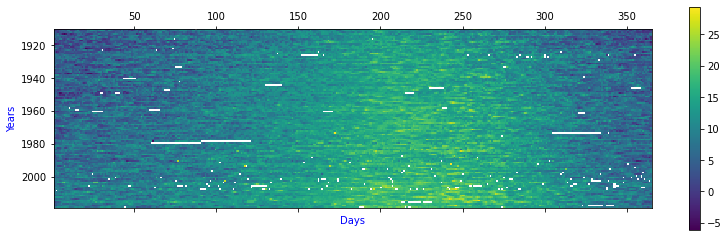

In [28]:
# show stacked array as colored map, specifying axis values,
# and creating temperature-reference colorbar

pp.matshow(allyears['TMIN'], extent=[1,365,2019,1910])
pp.colorbar()
pp.xlabel('Days', color= 'blue')
pp.ylabel('Years', color='blue')

In [12]:
#Observation from the above plot- Winter and summer nights getting warmer towards the end of the century.

# min and max of TMIN/TMAX along all years, excluding NaNs

tmin_record = np.nanmin(allyears['TMIN'], axis=0)
tmax_record = np.nanmax(allyears['TMAX'], axis=0)

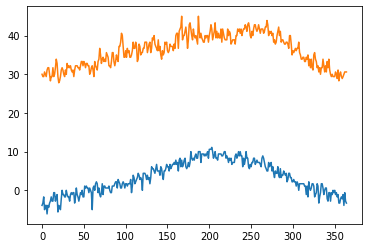

In [13]:
pp.plot(tmin_record)
pp.plot(tmax_record)

In [14]:
# for normals: get TMIN/TMAX arrays for years 1981-2010, stack vertically in array

normal = np.vstack([getweather.getyear('PASADENA', ['TMIN','TMAX'], year)
                    for year in range(1981, 2011)])

In [15]:
# mean of TMIN/TMAX across 1981-2010 years, excluding NaNs

tmin_normal = np.nanmean(normal['TMIN'], axis=0)
tmax_normal = np.nanmean(normal['TMAX'], axis=0)

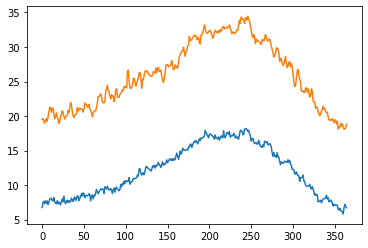

In [16]:
pp.plot(tmin_normal)
pp.plot(tmax_normal)

In [17]:
station, year = 'PASADENA', 2018

thisyear = getweather.getyear(station, ['TMIN', 'TMAX'], year)

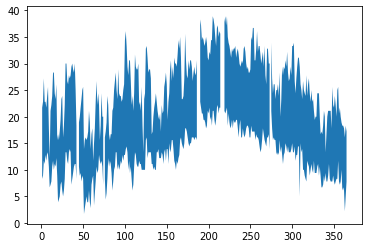

In [18]:
# fill area between horizontal curves (days, thisyear['TMIN']) and (days, thisyear['TMAX'])

days = np.arange(1, 366)

pp.fill_between(days, thisyear['TMIN'], thisyear['TMAX'])

In [19]:
#calculating average temperature for the year in 'PASADENA'
avg = 0.5*(np.nanmean(thisyear['TMIN']) + np.nanmean(thisyear['TMAX']))

In [20]:
# formatted string literal: will insert values of variable in braces
f'{station}, {year}: average temperature = {avg:.2f} C'

'PASADENA, 2018: average temperature = 19.46 C'

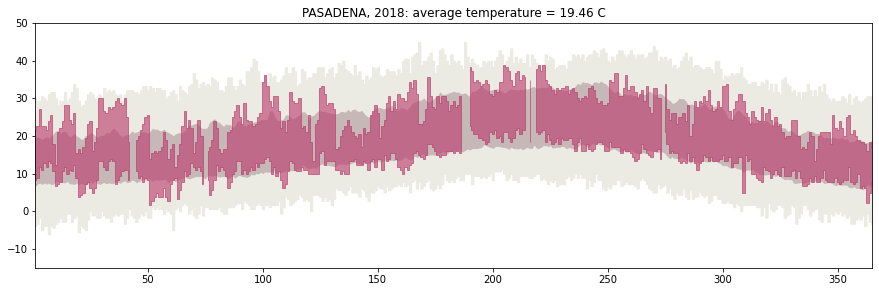

In [21]:
# show normals, records, and current year bands together

pp.figure(figsize=(15,4.5))

pp.fill_between(days, tmin_record, tmax_record, color=(0.92,0.92,0.89), step='mid')
pp.fill_between(days, tmin_normal, tmax_normal, color=(0.78,0.72,0.72))

pp.fill_between(days, thisyear['TMIN'], thisyear['TMAX'],
                color=(0.73,0.21,0.41), alpha=0.6, step='mid')

pp.axis(xmin=1, xmax=365, ymin=-15, ymax=50)

pp.title(f'{station}, {year}: average temperature = {avg:.2f} C');

In [30]:
# collect data and make chart for any city and current year,
# following the same steps as above

def anyplot(station, year):
    pp.figure(figsize=(15,4.5))
    
    allyears = np.vstack([getweather.getyear(station, ['TMIN','TMAX'], year)
                          for year in range(1910, 2020)])
    
    normal = np.vstack([getweather.getyear(station, ['TMIN','TMAX'], year)
                        for year in range(1981, 2011)])

    tmin_record, tmax_record = np.nanmin(allyears['TMIN'], axis=0), np.nanmax(allyears['TMAX'], axis=0)
    tmin_normal, tmax_normal = np.nanmean(normal['TMIN'], axis=0), np.nanmean(normal['TMAX'], axis=0)

    days = np.arange(1, 366)

    pp.fill_between(days, tmin_record, tmax_record, color=(0.92,0.92,0.89), step='mid')
    pp.fill_between(days, tmin_normal, tmax_normal, color=(0.78,0.72,0.72))
    
    thisyear = getweather.getyear(station, ['TMIN', 'TMAX'], year)

    pp.fill_between(days, thisyear['TMIN'], thisyear['TMAX'], color=(0.73,0.21,0.41), alpha=0.6, step='mid')

    pp.axis(xmin=1, xmax=365, ymin=-15, ymax=50)
    
    avg = 0.5*(np.nanmean(thisyear['TMIN']) + np.nanmean(thisyear['TMAX']))
    pp.title(f'{station}, {year}: average temperature = {avg:.2f} C');

KeyError: ignored

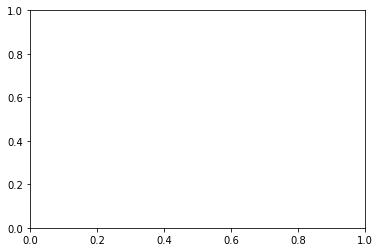

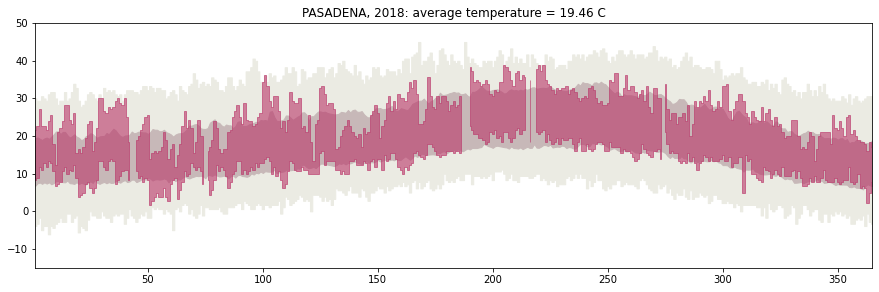

<Figure size 1080x324 with 0 Axes>

In [32]:
#plots for four (4) cities in the U.S for year 2018
#pp.figure(figsize=(12,9))

for i, city in enumerate(['PASADENA','NEW YORK','SAN DIEGO','MINNEAPOLIS']):
    pp.subplot()
    anyplot(city, 2018)

In [33]:
# Create a general function to smooth any array--to reduce noise

def smooth_array(array, window=10, mode='valid'):
    return np.correlate(array, np.ones(window)/window, mode)

In [34]:
# get all historical data for New York, stacked into array

station = 'NEW YORK'

allyears = np.arange(1880, 2020)

alldata = np.vstack([getweather.getyear(station, ['TMIN','TMAX'], year)
                     for year in allyears])

KeyError: ignored

In [35]:
import math
import collections
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [ ]:
#NOAA stands for the "National Oceanic and Atmospheric Administration" a US govt agency.
#NOAA has its own integrated database called "GHCN" where it stores daily climate
#summaries from land surfaces across the globe.

#GHCN-contains records from over 100000 stations in 180 countries and territories.

#N.C.E.I provides numerous daily variables, including maximum and minimum temperature,
#total daily precipitation, snowfall, and snow depth.

#Both the record length and period of record vary by stations and cover intervals

#ranging from less than a year to more than 175 years.

In [36]:
#download the 'readme.txt' file from the NOAA website
urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt',
                           'readme.txt')

('readme.txt', <http.client.HTTPMessage at 0x7f4b657e1100>)

# IV. FORMAT OF "ghcnd-stations.txt"
Variable Columns Type
ID 1-11 Character LATITUDE 13-20 Real LONGITUDE 22-30 Real ELEVATION 32-37 Real STATE 39-40 Character NAME 42-71 Character GSN FLAG 73-75 Character HCN/CRN FLAG 77-79 Character WMO ID 81-85 Character

In [37]:
# loading a fixed-width text file: we prescribe the widths of every field;
# the names of the resulting array columns; their datatypes. 'Uxx' stands
# for unicode string of length xx; 'd' for double precision floating point

stations = np.genfromtxt('stations.txt', delimiter=[11,9,10,7,3,31,4,4,6],
                                         names=['id','latitude','longitude','elevation','state','name',
                                                'gsn','hcn','wmo'],
                                         dtype=['U11','d','d','d','U3','U31','U4','U4','U6'],
                                         autostrip=True)

In [38]:
stations

array([('ACW00011604',  17.1167, -61.7833,   10.1, '', 'ST JOHNS COOLIDGE FLD', '', '', ''),
       ('ACW00011647',  17.1333, -61.7833,   19.2, '', 'ST JOHNS', '', '', ''),
       ('AE000041196',  25.333 ,  55.517 ,   34. , '', 'SHARJAH INTER. AIRP', 'GSN', '', '41196'),
       ...,
       ('ZI000067977', -21.017 ,  31.583 ,  430. , '', 'BUFFALO RANGE', '', '', '67977'),
       ('ZI000067983', -20.2   ,  32.616 , 1132. , '', 'CHIPINGE', 'GSN', '', '67983'),
       ('ZI000067991', -22.217 ,  30.    ,  457. , '', 'BEITBRIDGE', '', '', '67991')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

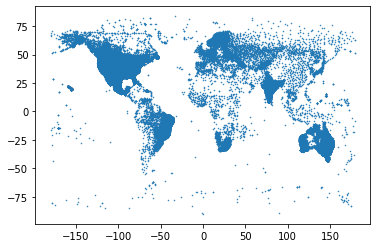

In [39]:
#Plot the LONGITUDE and LATITUDE to have an idea of the global coverage of the database
pp.plot(stations['longitude'], stations['latitude'], '.', markersize=1)

In [40]:
#Stations in california
stations_ca = stations[stations['state'] == 'CA']

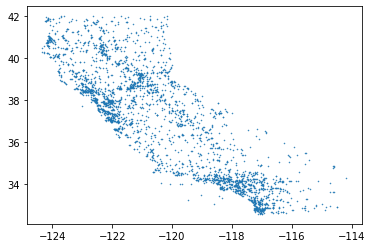

In [41]:
pp.plot(stations_ca['longitude'], stations_ca['latitude'], '.', markersize=1)

In [42]:
#locate the 'PASADENA' station in california state.
stations[stations['name'] == 'PASADENA']

array([('USC00046719', 34.1483, -118.1447, 263.3, 'CA', 'PASADENA', '', 'HCN', '')],
      dtype=[('id', '<U11'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('state', '<U3'), ('name', '<U31'), ('gsn', '<U4'), ('hcn', '<U4'), ('wmo', '<U6')])

In [43]:

#Query to find all stations with name 'PASADENA'
stations[np.char.find(stations['name'], 'PASADENA') == 0]

array([('CA1NL000026', 49.0094,  -57.5849,  52.4, 'NL', 'PASADENA 0.5 SE', '', '', ''),
       ('US1CALA0036', 34.1392, -118.1161, 225.2, 'CA', 'PASADENA 2.0 SE', '', '', ''),
       ('US1CALA0043', 34.1619, -118.1073, 277.7, 'CA', 'PASADENA 1.8 E', '', '', ''),
       ('US1CALA0091', 34.1648, -118.1249, 289. , 'CA', 'PASADENA 0.8 ENE', '', '', ''),
       ('US1MDAA0010', 39.1038,  -76.5443,  13.1, 'MD', 'PASADENA 0.7 SE', '', '', ''),
       ('US1MDAA0013', 39.1263,  -76.5596,  18.9, 'MD', 'PASADENA 1.1 NNW', '', '', ''),
       ('US1MDAA0039', 39.0916,  -76.5112,  10.7, 'MD', 'PASADENA 2.6 ESE', '', '', ''),
       ('US1TXHRR076', 29.6471,  -95.1895,  10.7, 'TX', 'PASADENA 2.4 WSW', '', '', ''),
       ('US1TXHRR084', 29.6339,  -95.1881,  11.9, 'TX', 'PASADENA 2.8 SW', '', '', ''),
       ('US1TXHRR093', 29.6849,  -95.2197,   9.1, 'TX', 'PASADENA 4.4 WNW', '', '', ''),
       ('US1TXHRR094', 29.6746,  -95.2104,   9.1, 'TX', 'PASADENA 3.6 WNW', '', '', ''),
       ('US1TXHRR305', 29.6

In [44]:
#Download station data for 'PASADENA' from the NOAA website
urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/USC00046719.dly', 'PASADENA.dly')

('PASADENA.dly', <http.client.HTTPMessage at 0x7f4b6582cd60>)

In [45]:
getweather.getyear('PASADENA', ['TMIN','TMAX'], 2000)

array([( 6.1, 14.4), ( 6.1, 18.3), ( 3.9, 18.3), ( 6.1, 20. ),
       ( 6.1, 20.6), ( 5.6, 20. ), ( 5.6, 18.3), ( 3.3, 21.7),
       ( 5. , 20.6), ( 6.1, 18.3), ( 6.7, 18.9), ( 8.3, 17.8),
       ( 7.8, 24.4), (11.1, 26.1), (12.8, 26.1), (13.3, 23.9),
       (13.3, 20.6), (13.9, 24.4), (11.1, 25.6), (12.8, 21.7),
       (11.7, 18.3), (10. , 18.3), ( 7.8, 20. ), (11.7, 22.8),
       (12.2, 21.7), ( 8.3, 20.6), ( 7.2, 20.6), ( 6.1, 21.7),
       ( 6.7, 21.7), (10. , 17.8), (11.1, 16.7), (13.3, 24.4),
       (11.1, 26.7), ( 9.4, 26.7), ( 8.9, 23.9), (10.6, 21.1),
       ( 6.7, 25. ), ( nan,  nan), (15.6, 26.7), (10. , 23.9),
       (10.6, 19.4), ( 5. , 18.3), ( 9.4, 17.8), ( 9.4, 15.6),
       (10.6, 16.7), ( 8.9, 19.4), (10. , 16.7), ( 7.2, 17.2),
       ( 6.1, 22.2), ( 7.8, 25. ), ( 9.4, 23.9), ( 6.7, 13.3),
       ( 7.2, 13.9), ( 7.8, 12.8), ( 2.8, 16.1), ( 8.3, 15. ),
       ( 5.6, 21.7), ( 8.3, 20.6), ( 4.4, 17.2), ( 7.2, 18.3),
       ( 6.7, 19.4), ( 7.2, 22.2), (17.2, 20. ), ( 7.2,

In [46]:
pasadena = getweather.getyear('PASADENA', ['TMIN', 'TMAX'], 2001)

In [47]:
#Total number of NaNs in the minimum temperature dataset
np.isnan(pasadena['TMIN']).sum()

15

In [48]:
#Try fill up NaN with average or mean temperature (min and max)
pasadena['TMIN'][np.isnan(pasadena['TMIN'])] = np.nanmean(pasadena['TMIN'])

In [49]:

pasadena['TMIN']

array([ 9.4       ,  8.3       ,  8.9       ,  8.3       , 10.        ,
       10.6       ,  7.2       ,  7.2       ,  7.8       ,  6.1       ,
        5.6       ,  6.1       ,  5.        ,  3.9       ,  4.4       ,
        2.8       ,  5.        ,  3.9       ,  5.6       ,  7.2       ,
        7.2       ,  8.9       ,  5.6       ,  6.7       ,  3.3       ,
        5.6       ,  3.3       ,  3.3       ,  3.3       ,  3.9       ,
        5.        ,  5.        ,  6.1       , 11.45314286,  7.2       ,
       13.9       , 11.1       ,  5.6       ,  2.2       ,  3.9       ,
        6.1       ,  3.3       ,  5.6       ,  6.1       ,  2.8       ,
        2.8       ,  4.4       ,  7.8       , 10.        ,  9.4       ,
        5.6       ,  5.6       ,  7.8       ,  5.        ,  3.9       ,
        6.7       ,  7.2       ,  7.8       ,  6.7       ,  5.        ,
        5.6       ,  8.3       ,  9.4       , 10.        ,  9.4       ,
       10.        ,  8.9       , 10.6       ,  6.1       ,  8.9 

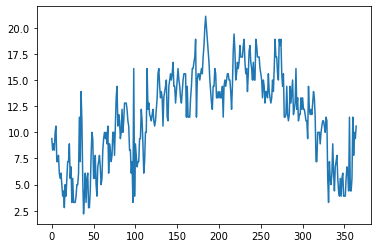

In [50]:

pp.plot(pasadena['TMIN'])

In [51]:
#Better alternative to use 'Linear Interpolation' technique to fill up missing values
#create a general function for filling up missing data using Linear interpolation in an array or data sets.

def fill_missing(array):
    good_data = ~np.isnan(array)
    x = np.arange(len(array))
    return np.interp(x, x[good_data], array[good_data])

In [52]:
#fill up missing data in Pasadena 'MIN' and 'MAX'
pasadena_min = fill_missing(pasadena['TMIN'])
pasadena_max = fill_missing(pasadena['TMAX'])

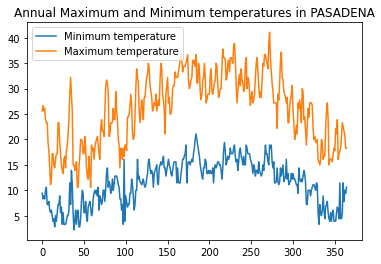

In [53]:
pp.plot(pasadena_min, label='Minimum temperature')
pp.plot(pasadena_max, label='Maximum temperature')
pp.title('Annual Maximum and Minimum temperatures in PASADENA')
pp.legend()

In [54]:
#load data for 'Hilo'
hilo = getweather.getyear('HILO', ['TMIN','TMAX'], 2000)

Using ('USW00021504', 19.7192, -155.0489, 8.8, 'HI', 'HILO INTL AP 87', 'GSN', '', '91285').


In [55]:
#clean dnd fill up missing values
fill_missing(hilo['TMIN'])
fill_missing(hilo['TMAX'])

array([26.7, 26.1, 26.7, 26.1, 24.4, 23.9, 23.3, 22.2, 23.3, 25.6, 23.9,
       23.3, 22.2, 25. , 24.4, 22.8, 23.3, 21.7, 23.9, 23.3, 23.9, 23.9,
       23.9, 23.9, 24.4, 23.9, 23.9, 23.9, 23.3, 25.6, 25.6, 25.6, 25.6,
       25.6, 26.1, 26.1, 26.7, 26.7, 27.2, 26.7, 26.7, 26.7, 27.2, 26.7,
       26.7, 27.8, 28.3, 27.8, 27.2, 25.6, 26.1, 26.7, 26.7, 27.2, 27.2,
       27.8, 27.2, 27.2, 27.2, 27.8, 26.7, 26.7, 27.2, 27.2, 26.7, 26.1,
       25. , 26.7, 27.8, 27.8, 27.8, 27.2, 27.2, 27.8, 27.8, 28.9, 27.2,
       25.6, 26.7, 27.2, 26.1, 26.1, 25.6, 24.4, 26.1, 25.6, 24.4, 24.4,
       25.6, 26.1, 26.7, 26.1, 25.6, 25. , 24.4, 22.8, 25. , 25.6, 25.6,
       21.7, 21.7, 22.8, 25. , 26.1, 26.7, 25.6, 25.6, 23.3, 25.6, 26.1,
       25. , 25.6, 27.2, 27.2, 25. , 26.1, 26.1, 25. , 26.7, 25.6, 26.7,
       26.7, 26.1, 27.8, 27.8, 27.2, 27.8, 28.3, 27.8, 27.2, 28.3, 26.1,
       27.2, 26.7, 26.7, 27.8, 27.2, 27.8, 26.7, 27.8, 27.2, 27.8, 26.7,
       27.8, 27.2, 27.8, 26.7, 27.2, 27.2, 27.8, 27

In [56]:
# Create a function to smoothen the time series

np.mean(hilo['TMIN']), np.min(hilo['TMIN']), np.max(hilo['TMIN'])

(19.102739726027398, 14.4, 23.3)

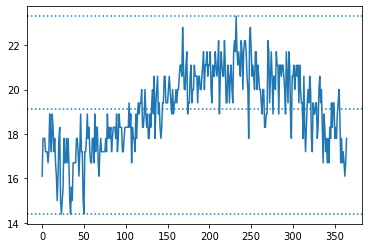

In [57]:
pp.plot(hilo['TMIN'])

# plot horizontal lines at mean, min, and max of TMIN data
for value in [np.mean(hilo['TMIN']), np.min(hilo['TMIN']), np.max(hilo['TMIN'])]:
    pp.axhline(value, linestyle=':')

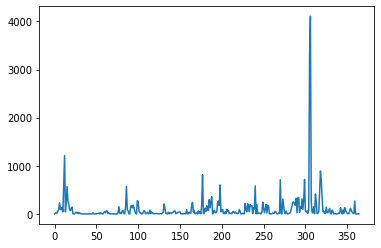

In [58]:
# Analyze precipitation data for 'HILO'

rain = getweather.getyear('HILO', ['PRCP'], 2000)['PRCP']

pp.plot(rain)

In [59]:
# Create a general function to smooth any array--to reduce noise

def smooth_array(array, window=10, mode='valid'):
    return np.correlate(array, np.ones(window)/window, mode)

Text(0, 0.5, 'Temp-Celsius')

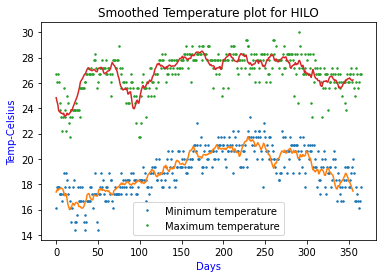

In [60]:
pp.plot(hilo['TMIN'], '.', label='Minimum temperature', ms=3)
pp.plot(smooth_array(hilo['TMIN'], 10))

pp.plot(hilo['TMAX'], '.',label='Maximum temperature', ms=3)
pp.plot(smooth_array(hilo['TMAX'], 10))
pp.title('Smoothed Temperature plot for HILO')
pp.legend()
pp.xlabel('Days', color= 'blue')
pp.ylabel('Temp-Celsius', color='blue')

In [61]:
# load TMIN and TMAX data for a station and year; fill NaNs;
# plot unsmoothed data as dots, smoothed data as lines,
# dropping boundary values and adjusting x axis consistently

def smooth_dataset(station, year):
    stationdata = getweather.getyear(station, ['TMIN','TMAX'], year)

    for obs in ['TMIN','TMAX']:   
        stationdata[obs] = fill_missing(stationdata[obs])
    
        # thinner points
        pp.plot(stationdata[obs], '.', ms=1)
        pp.plot(range(10,356), smooth_array(stationdata[obs], 20))
    
    pp.title(station)
    pp.axis(xmin=1, xmax=365, ymin=-10, ymax=45)

Text(0, 0.5, 'Temp-Celsius')

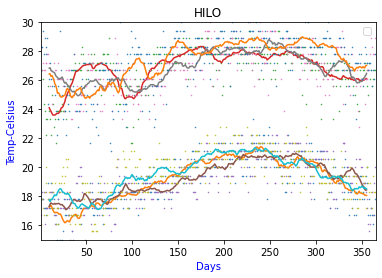

In [62]:
smooth_dataset('HILO', 2000)
smooth_dataset('HILO', 2001)
smooth_dataset('HILO', 2002)

pp.axis(ymin=15,ymax=30)
pp.legend()
pp.xlabel('Days', color= 'blue')
pp.ylabel('Temp-Celsius', color='blue')

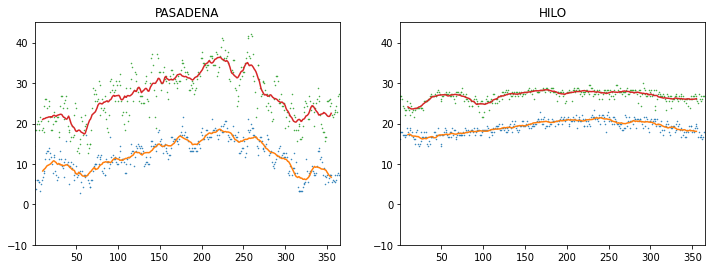

In [64]:
# Comparison of the weather in different cities in the U.S

#plots for four (4) cities in the U.S for year 2000
pp.figure(figsize=(12,9))

for i, city in enumerate(['PASADENA','HILO']):
    pp.subplot(2,2,i+1)
    smooth_dataset(city, 2000)

In [ ]:
# Comparison of the weather in different cities in the U.S

#plots for four (4) cities in the U.S for year 2000
pp.figure(figsize=(12,9))

for i, city in enumerate(['PASADENA','NEW YORK','SAN DIEGO','MINNEAPOLIS']):
    pp.subplot(2,2,i+1)
    smooth_dataset(city, 2000)